# Install packages



In [ ]:
# Library required in training section. After installing, restart the kernel.
!pip install --use-deprecated=legacy-resolver pycaret[full] && pip install markupsafe==2.0.1

     |████████████████████████████████| 320 kB 4.6 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 1.3 MB 35.4 MB/s 
     |████████████████████████████████| 2.0 MB 37.3 MB/s 
     |████████████████████████████████| 167 kB 21.1 MB/s 
     |████████████████████████████████| 6.8 MB 16.5 MB/s 
     |████████████████████████████████| 120 kB 37.7 MB/s 
     |████████████████████████████████| 16.8 MB 649 kB/s 
     |████████████████████████████████| 1.7 MB 37.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 262 kB 39.5 MB/s 
     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 92 kB 105 kB/s 
     |████████████████████████████████| 62 kB 371 kB/s 
     |████████████████████████████████| 305 kB 36.1 MB/s 
     |██████████████████████

In [ ]:
!pip install kaggle --upgrade

# Imports

In [ ]:
# numpy stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# general
import re
import os
from string import digits
import time

# nltk
import nltk
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, precision_recall_curve, f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV, cross_validate


# scipy
from scipy import sparse

#  word embeddings
import gensim.downloader as GensimDownloader
from gensim.models import Word2Vec, KeyedVectors

# plt.style
plt.style.use('default')

# inline to include plots
%matplotlib inline


# Kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'giannislakkas'
os.environ['KAGGLE_KEY'] = '9181860ede8d79ed87da011b601b71aa'

# Kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
!kaggle competitions download -c twitter-sentiment-analysis2
! mkdir twitter
! unzip twitter-sentiment-analysis2.zip -d twitter

 62% 9.00M/14.6M [00:00<00:00, 83.7MB/s]
100% 14.6M/14.6M [00:00<00:00, 118MB/s] 
Archive:  twitter-sentiment-analysis2.zip
  inflating: twitter/test.csv        
  inflating: twitter/train.csv       


# Downloads

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Develop a sentiment classifier for a kind of texts of your choice 

# To Do:

* Use an existing sentiment analysis dataset with at least two classes$^2$.

$^2$ See, for example, the Large Movie Review Dataset (http://ai.stanford.edu/~amaas/data/sentiment/), the Cornell Movie Review Data (http://www.cs.cornell.edu/people/pabo/movie-review-data/, included in NLTK), or the Twitter Sentiment Analysis Dataset (https://www.kaggle.com/c/twitter-sentiment-analysis2/data, you need to create a Kaggle account).

* The classes should be mutually exclusive, i.e., this is a single-label multi-class classification problem.

## Download Dataset

* We opted for the [Twitter Sentiment Analysis Dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data). In order to load the file, the kaggle.json file need to be uploaded when prompted.

* The dataset consists of a train and test set, which will be added to a `./twitter` folder.

## Load files

* The `train.csv` and `test.csv` files will be combined into a single dataframe, which will be later be used for the train/test split. 

In [ ]:
df1, df2 = pd.read_csv('./twitter/train.csv', delimiter=',',  encoding="latin-1"), pd.read_csv('./twitter/train.csv', delimiter=',',  encoding="latin-1")
frames = [df1, df2]

In [ ]:
data = pd.concat(frames)

# delete temp dataframes
del df1, df2

data.drop(columns='ItemID', inplace=True)
data.shape

(199978, 2)

In [ ]:
data.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


* Let's see how balanced the targets are:

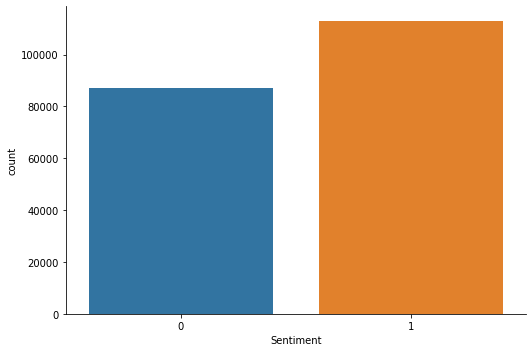

In [ ]:
_ = sns.catplot(x='Sentiment',data=data,kind='count',height=5,aspect=1.5)

## Pre-processing

* Having downloaded our data, we will perform a set of pre-processing steps, in order to bring the text to a "clean" format. More details, regarding the steps, are added as comments in the function `preprocess`.

In [ ]:
# initialize lemmatizer
stemmer = WordNetLemmatizer()

# define trans for digits
remove_digits = str.maketrans('', '', digits)

Below are some examples of some additional cases that need to be included since we are working with tweets: 
1. Twitter usernames (@user)
2. Websites (Http)

In [ ]:
print("Tweet with user tag:\t", data[data['SentimentText'].str.contains("@")==True].SentimentText.iloc[0])
print("Tweet with website:\t", data[data['SentimentText'].str.contains("http")==True].SentimentText.iloc[0])

Tweet with user tag:	       hmmmm.... i wonder how she my number @-)
Tweet with website:	     awhhe man.... I'm completely useless rt now. Funny, all I can do is twitter. http://myloc.me/27HX


In [ ]:
def preprocess(sentence):
    """
    Function to process a given sentence.
    INPUT: raw string (tweet)
    OUTPUT: processed string 
    """
    #convert the sentence to lower
    sentence = sentence.lower()
    
    # Remove underscores 
    sentence = re.sub(r'[-_]', '', sentence)
    sentence = re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    sentence = re.sub(r'^ _\s+', ' ', sentence)

    # Remove twitter usernames
    sentence = re.sub(r'@\w+', ' ', sentence)

    # Remove websites
    sentence = re.sub('https?://[A-Za-z0-9./]+', ' ', sentence)

    #remove all non words
    sentence = re.sub(r'\W', ' ', sentence)

    #remove all single characters
    sentence = re.sub(r'\b\w\b', ' ', sentence)

    # Remove numbers
    sentence = re.sub(r'[0-9]', ' ', sentence)
    sentence = sentence.translate(remove_digits)

    #remove multiple whitespaces
    sentence = re.sub(' +', ' ', sentence)

    # Split the sentence based on whitespaces (--> List of words)
    sentence = sentence.split()
    
    # Lemmatization
    sentence = [stemmer.lemmatize(word) for word in sentence]
    
    # Reconstruct the sentence by joining the words on each whitespace
    sentence = ' '.join(sentence)
    return sentence

* We will apply the `preprocess` function to the dataset and keep the results in a new column to have an overview of the results.

In [ ]:
data['text']= data['SentimentText'].apply(lambda row: preprocess(row))
data.head()

,Sentiment,SentimentText,text
0,0,is so sad for my APL frie...,is so sad for my apl friend
1,0,I missed the New Moon trail...,missed the new moon trailer
2,1,omg its already 7:30 :O,omg it already
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im sooo im gunna cry ve been at this de...
4,0,i think mi bf is cheating on me!!! ...,think mi bf is cheating on me tt


## Train/Dev/Test split

* Now that the the dataset has been pre-processed we can split the data into a Train, Dev and Test set. Due to the large amount of data we followed the following strategy:
* A train/test split of 0.7/0.3 ratio, respectively, will initially take place. The output will be saved in the following variables:
`X_train_total` & `X_test`.
* Given that we will use sklearn with Cross validation for the development, we will split the `X_train_total` variable into two other variables, `X_train` & `X_dev` with a 50/50 split. This is done in order to avoid RAM issues (due to google colab) and speed up the optimization.

In [ ]:
# Define X, y
X, y  = data['text'], data['Sentiment']

# Define Train/Dev/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=42)
# Keep the total X and y train datasets
X_train_total = X_train
y_train_total = y_train
# Extract a part of the train set as dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, shuffle=True, random_state=42)

In [ ]:
print(f"""{'Train size:':<12} {X_train.shape[0]:>6}
{'Dev size:':<12} {X_dev.shape[0]:>6}
{'Test size:':<12} {X_test.shape[0]:>6}""")

Train size:   74991
Dev size:     74992
Test size:    49995


## Features

### Unigram and bi-gram TF-IDF features

In [ ]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 5000,
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - dev - test)
X_train_total_tfidf = vectorizer.fit_transform(X_train_total)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_dev_tfidf = vectorizer.transform(X_dev)


print(vectorizer.get_feature_names()[:130])

['aaron', 'abby', 'abit', 'able', 'able get', 'able go', 'able make', 'absolute', 'absolutely', 'abt', 'ac', 'accent', 'accept', 'accepted', 'access', 'accident', 'accidentally', 'according', 'account', 'ace', 'ache', 'acoustic', 'across', 'act', 'act like', 'acting', 'action', 'active', 'actor', 'actress', 'actual', 'actually', 'ad', 'ada', 'adam', 'add', 'add everyone', 'added', 'addicted', 'addiction', 'adding', 'address', 'admit', 'adorable', 'adore', 'adult', 'advance', 'advantage', 'adventure', 'advert', 'advice', 'afford', 'afraid', 'afternoon', 'afterwards', 'age', 'ago', 'agree', 'agreed', 'ah', 'ah well', 'aha', 'ahah', 'ahaha', 'ahead', 'ahh', 'ahhh', 'ahhhh', 'ahhhhh', 'ai', 'aim', 'aint', 'air', 'air france', 'airport', 'aj', 'aka', 'ako', 'al', 'ala', 'alan', 'alarm', 'album', 'alcohol', 'alex', 'ali', 'alice', 'alien', 'alike', 'alive', 'allen', 'allergic', 'allergy', 'allison', 'allow', 'allowed', 'ally', 'almost', 'almost done', 'alone', 'along', 'alot', 'already', 'al

In [ ]:
print('Shape of training data: {}'.format(X_train_tfidf.shape))
print('Shape of test data: {}\n'.format(X_test_tfidf.shape))

print(X_test_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data: (74991, 5000)
Shape of test data: (49995, 5000)

  (0, 4698)	0.27950731392049255
  (0, 4589)	0.17894704608247167
  (0, 4165)	0.32294840362786775
  (0, 3897)	0.29076092316910784
  (0, 3761)	0.36173820295596154
  (0, 3359)	0.2967048192752623
  (0, 3055)	0.3275498247543668
  (0, 2984)	0.21914146969486528
  (0, 2730)	0.28780831266361534
  (0, 1686)	0.21707109504327882
  (0, 1028)	0.4436917809450465


### Bag of Words (BOW)

In [ ]:
cv= CountVectorizer(binary=False, min_df=0.0, max_df=1.0 , ngram_range=(1,2), 
                    max_features = 5000,stop_words = stopwords.words('english'))

X_train_total_cv = cv.fit_transform(X_train_total)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)
X_dev_cv = cv.transform(X_dev)

print('BOW model:> Train features shape:', X_train_cv.shape, X_test_cv.shape)

BOW model:> Train features shape: (74991, 5000) (49995, 5000)


### Word embeddings

In [ ]:
w2v_model = GensimDownloader.load("glove-twitter-200")
tf_idf_vectorizer_words = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
def word2vec_embed_sentence(sentence:str, w2v_model:Word2Vec):
    '''
        Computes the mean vector of all Word2Vec embeddings of a given sentence.
        
        :param sentence: Input sentence.
        :param w2v_model: Word2Vec binary model.
        
        :returns: mean vector (Numpy 200-dim row vector).
    '''
    
    # Split and remove stopwords (too slow).
    # words = [word for word in sentence.split() if word not in stopwords.words('english')]
    
    words = sentence.split()
    
    # Create a mxn matrix to store a single sentence's word embeddings.
    word_embeddings = np.zeros((len(words), 200))
    
    # Create an m-vector to hold TF/IDF scores of each word.
    tfidf_embeddings = np.zeros((len(words), 1))
    
    for i, word in enumerate(words):
        if word in w2v_model.vocab and word in tf_idf_vectorizer_words:
            word_embeddings[i, :] = w2v_model[word]
            tfidf_embeddings[i, 0] = tf_idf_vectorizer_words[word]
            
    # Compute the centroid of the sentence.
    t_centroid = np.sum(word_embeddings * tfidf_embeddings, axis = 0) / np.sum(tfidf_embeddings)
    
    return t_centroid

def word2vec_embed_X(X:np.ndarray, w2v_model:Word2Vec):
    '''
        Computes Word2Vec embeddings for an entire input set.
        
        :param X: Input set.
        :param w2v_model: Word2Vec binary model.
        
        :returns: Matrix of Word2Vec embeddings (len(X)x200 matrix).
    '''
    
    # Create a len(X)x200 matrix to store the entire set word embeddings.
    sentence_embeddings = np.zeros((len(X), 200))
    
    for i, x in enumerate(X):
        sentence_embeddings[i, :] = word2vec_embed_sentence(x, w2v_model)
    
    return sentence_embeddings

In [ ]:
w2v_vectorized_x_train_total = word2vec_embed_X(X_train_total, w2v_model)
w2v_vectorized_x_train = word2vec_embed_X(X_train, w2v_model)
w2v_vectorized_x_dev = word2vec_embed_X(X_dev, w2v_model)
w2v_vectorized_x_test = word2vec_embed_X(X_test, w2v_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
w2v_vectorized_x_train_total = SimpleImputer(strategy = "mean").fit_transform(w2v_vectorized_x_train_total)
w2v_vectorized_x_train = SimpleImputer(strategy = "mean").fit_transform(w2v_vectorized_x_train)
w2v_vectorized_x_dev = SimpleImputer(strategy = "mean").fit_transform(w2v_vectorized_x_dev)
w2v_vectorized_x_test = SimpleImputer(strategy = "mean").fit_transform(w2v_vectorized_x_test)

### Dimensionality reduction

We use the TruncatedSVD algorithm to achieve dimensionality reduction for our feature vectors. The below function calculates the cutoff threshold for the number of components.

In [ ]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        
        if total_variance >= goal_var:
            break
            
    return n_components

TruncatedSVD - TFIDF

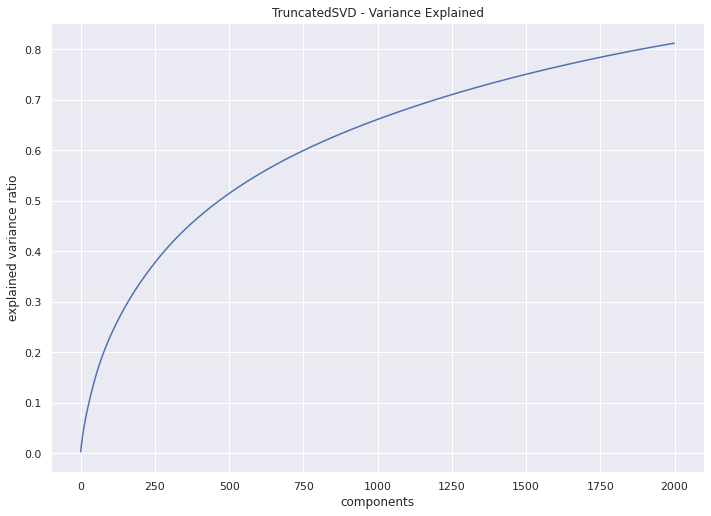

Number of components for 95%:  2000


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=2000, random_state=4321)
svd.fit(X_train_tfidf)

plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('TruncatedSVD - Variance Explained')
plt.xlabel('components')
plt.ylabel('explained variance ratio')
plt.show()

k = select_n_components(svd.explained_variance_ratio_, 0.95)
print("Number of components for 95%: ", k)

In the above plot, we observe that we achieve to explain ~80% of the variance by using 2000 components. This reduces our original feature vector length by more than 50%. However, 80% is not an accepted percentage. Beacuse our resources (RAM) are not enough for calculating more components, we decide to disregard the dimensionality reduction step.

In [ ]:
#svd = TruncatedSVD(n_components=k, random_state=4321)
#svd.fit(X_train_tfidf)
#X_train_tfidf_trunc = svd.transform(X_train_tfidf)
#X_dev_tfidf_trunc = svd.transform(X_dev_tfidf)
#X_test_tfidf_trunc = svd.transform(X_test_tfidf)

TruncatedSVD - BOW

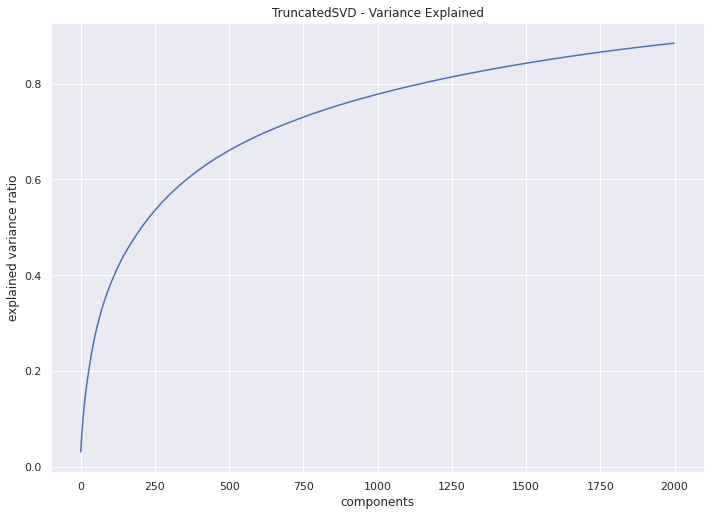

Number of components for 95%:  2000


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=2000, random_state=4321)
svd.fit(X_train_cv)

plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('TruncatedSVD - Variance Explained')
plt.xlabel('components')
plt.ylabel('explained variance ratio')
plt.show()

k = select_n_components(svd.explained_variance_ratio_, 0.95)
print("Number of components for 95%: ", k)

In the above plot, we observe that we achieve to explain ~90% of the variance by using 2000 components. This reduces our original feature vector length by more than 50%. However, 90% is not an accepted percentage. Beacuse our resources (RAM) are not enough for calculating more components, we decide to disregard the dimensionality reduction step.

In [ ]:
#svd = TruncatedSVD(n_components=k, random_state=4321)
#svd.fit(X_train_cv)
#X_train_cv_trunc = svd.transform(X_train_cv)
#X_dev_cv_trunc = svd.transform(X_dev_cv)
#X_test_cv_trunc = svd.transform(X_test_cv)

TruncatedSVD - Word Embeddings

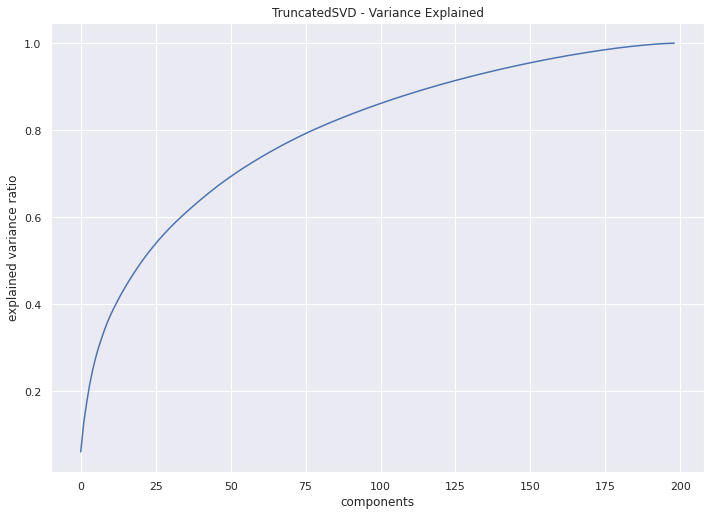

Number of components for 95%:  148


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=w2v_vectorized_x_train.shape[1]-1, random_state=4321)
svd.fit(w2v_vectorized_x_train_total)

plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('TruncatedSVD - Variance Explained')
plt.xlabel('components')
plt.ylabel('explained variance ratio')
plt.show()

k = select_n_components(svd.explained_variance_ratio_, 0.95)
print("Number of components for 95%: ", k)

In [ ]:
svd = TruncatedSVD(n_components=k, random_state=4321)
w2v_vectorized_x_train_total = svd.fit_transform(w2v_vectorized_x_train_total)
w2v_vectorized_x_train_trunc = svd.transform(w2v_vectorized_x_train)
w2v_vectorized_x_dev_trunc = svd.transform(w2v_vectorized_x_dev)
w2v_vectorized_x_test_trunc = svd.transform(w2v_vectorized_x_test)

## Classification

* The following part demonstrates our solution for the classification task. There are three pillar to the analysis:
1. `DummyClassifier`: A classifier that assigns the most frequent class of the training data. The results obtained from the next methods will be compared to this one.
2. `LogisticRegression`: Two-class logistic regression classifier, using sklearn. This model will be tuned in order to obtain the best result
3. `PyCaret`: Using the MLops solution we will create a pipeline to compare a handfull of models and select the best.

### Functions 

In [ ]:
# DEVELOPMENT PROCESS

# Randomized search cross validation
def development(x, y):
  grid = {"C":np.logspace(-4, 4, 20), "penalty":["l1","l2"], "solver":["newton-cg", "lbfgs", "liblinear", "sag"], "max_iter":[10000]}
  # C: Inverse of regularization strength; must be a positive float.
  # l1-lasso, l2-ridge and elasticnet-both l1 and l2
  log_reg = LogisticRegression()
  log_reg_cv = RandomizedSearchCV(log_reg, grid, random_state=0, n_iter=10)
  log_reg_cv.fit(x, y)

  print("Best hyerparameters:", log_reg_cv.best_params_)
  print("Best score:", log_reg_cv.best_score_)

  # Keep the best hyperparameters in a list in order to use them for the training part.
  best_params = log_reg_cv.best_params_
  print("The best hyperparameters from the model with the best score are the following:", best_params)
    
  # DEVELOPMENT METRICS
  dev_predictions = log_reg_cv.predict(x)
  score_dev = f1_score(y, dev_predictions)
  print("dev f1-score: %.2f%%"%(score_dev*100))
  print(classification_report(y, dev_predictions))

  
  cm_test = confusion_matrix(y, dev_predictions)
  disp = ConfusionMatrixDisplay(cm_test)
  disp.plot()
  _ = disp.ax_.set_title("DEVELOPMENT SET")
  print()

  return best_params

In [ ]:
# TRAINING & TEST METRICS
def training_metrics_and_fit(best_params, x_train, y_train):
  # Create the model with the best hyperparameters according to the Randomized Search CV
  log_reg_opt = LogisticRegression(**best_params)

  # Train the model
  log_reg_opt = log_reg_opt.fit(x_train, y_train)

  train_predictions = log_reg_opt.predict(x_train)
  train_score = f1_score(y_train, train_predictions)
  print("train f1-score: %.2f%%"%(train_score*100))
  print(classification_report(y_train, train_predictions))

  cm_test = confusion_matrix(y_train, train_predictions)
  disp = ConfusionMatrixDisplay(cm_test)
  disp.plot()
  #disp.plot() 
  disp.ax_.set_title("TRAINING SET")
  print()

  return log_reg_opt


def testing(opt_model, x_test, y_test):
  # Test the model
  y_pred = opt_model.predict(x_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(opt_model.score(x_test, y_test)))

  test_score = f1_score(y_test, y_pred)
  print("test f1-score: %.2f%%"%(test_score*100))
  print(classification_report(y_test, y_pred))

  cm_test = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(cm_test)
  disp.plot()
  disp.ax_.set_title("TEST SET")
  print()

In [ ]:
# PRECISION-RECALL CURVE
def prec_rec(opt_model, x_train, y_train):

  # We use the probabilities because the precision_recall_curve function needs them
  pred = opt_model.predict_proba(x_train)
  # model.predict() returns outputs of 0 or 1
  # model.predict_proba() returns an array: [P(x=0), P(x=1)]

  precision, recall, thresholds = precision_recall_curve(y_train, pred[:,1])
  area = auc(recall, precision)
  plt.figure(figsize=(8,6))
  plt.plot(recall, precision, label='Precision-Recall curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall Logistic Regression with TF-IDF: AUC=%0.2f' % (area))
  plt.legend(loc="lower left")
  plt.show()

In [ ]:
#CHANGED
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1_macro', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

In [ ]:
#CHANGED
def learning_metrics(best_params, x_train, y_train, x_dev, y_dev, x_test, y_test):

    clf = LogisticRegression(**best_params)
    start_time = time.time()
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_train)
    score = f1_score(y_train, predictions)
    auc_train = roc_auc_score(y_train, predictions, average=None)
    macro_auc_train = roc_auc_score(y_train, predictions, average='macro')
    report_train = classification_report(y_train, predictions,output_dict=True)
    train_df = pd.DataFrame.from_dict(report_train)
    disp.ax_.set_title("TRAINING SET")
    plot_learning_curve(clf,'TRAIN',x_train, y_train)

    

    predictions_dev = clf.predict(x_dev)
    score_dev = f1_score(y_dev, predictions_dev)
    auc_dev = roc_auc_score(y_dev, predictions_dev, average=None)
    report_dev = classification_report(y_dev, predictions_dev,output_dict=True)
    dev_df = pd.DataFrame.from_dict(report_dev)
    plot_learning_curve(clf,'DEV',x_dev, y_dev)



    predictions_test = clf.predict(x_test)
    score_test = f1_score(y_test, predictions_test)
    auc_test = roc_auc_score(y_test, predictions_test,  average=None)
    report_test = classification_report(y_test, predictions_test,output_dict=True)
    test_df = pd.DataFrame.from_dict(report_test)
    plot_learning_curve(clf,'TEST',x_test, y_test)



### Dummy Classifier (Base)

Training took: 0.00 seconds 

Train accuracy: 56.46%
Test accuracy: 56.46% 

#Class 0 in Train dataset: (32649,)
#Class 1 in Train dataset: (42342,)

Confusion Matrix for test data:


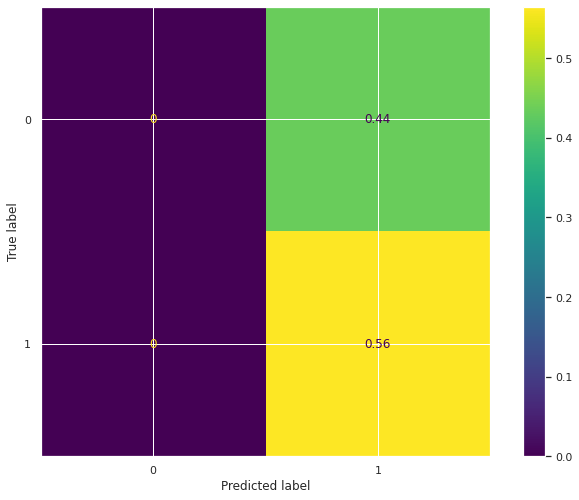

In [ ]:
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train, y_train)
print("Training took: {:.2f} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = baseline.predict(X_train)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_test = baseline.predict(X_test)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

cm_test = confusion_matrix(y_test, predictions_test, normalize='pred')

print("\nConfusion Matrix for test data:")
disp = ConfusionMatrixDisplay(cm_test)
_ = disp.plot()

### Logistic Regression

#### Cross - Validation for TF-IDF, BOW and Word Embeddings
* In order to select the model with the best performance and then optimize it using Randomized Search Cross Validation, we will run a 10-fold CV for the three datasets.

In [ ]:
cv_results_tfidf = cross_validate(LogisticRegression(max_iter=10000), X_train_total_tfidf, y_train_total, cv=10)
cv_results_bow = cross_validate(LogisticRegression(max_iter=10000), X_train_total_cv, y_train_total, cv=10) 
cv_results_emb = cross_validate(LogisticRegression(max_iter=10000), w2v_vectorized_x_train_total, y_train_total, cv=10) 


In [ ]:
print("TF-IDF average score:", round(cv_results_tfidf['test_score'].mean(),4))
print("BOW average score:", round(cv_results_bow['test_score'].mean(),4))
print("Word Embeddings average score:", round(cv_results_emb['test_score'].mean(),4))

TF-IDF average score: 0.7606
BOW average score: 0.7583
Word Embeddings average score: 0.7232


* Now that we have the cross validation scores, we have an idea of the performance. 

* We will proceed with optimizing all models. It's worth mentioning that for the optimization we will use the Randomized Search Cross Validation for a subset of the training data set in order to reduce the running time, because the training data set is quite large. This subset is split into train and dev sets in order to perform the optimization.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


Best hyerparameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 1.623776739188721}
Best score: 0.7547338245005994
The best hyperparameters from the model with the best score are the following: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 1.623776739188721}
dev f1-score: 81.86%
              precision    recall  f1-score   support

           0       0.78      0.70      0.74     32649
           1       0.79      0.85      0.82     42343

    accuracy                           0.79     74992
   macro avg       0.79      0.78      0.78     74992
weighted avg       0.79      0.79      0.79     74992




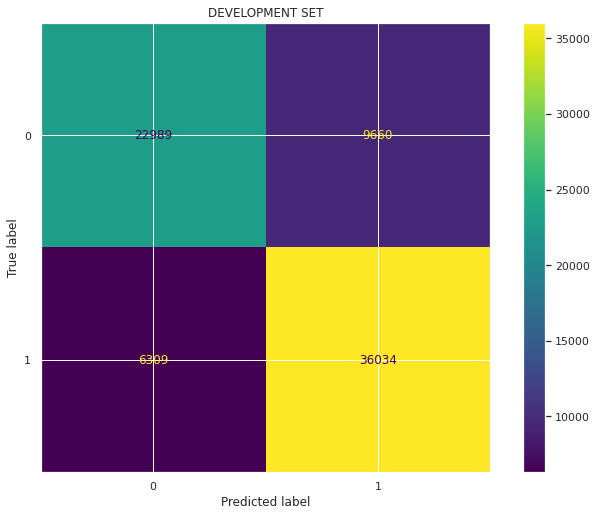

In [ ]:
best_params_tfidf = development(X_dev_tfidf, y_dev)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


Best hyerparameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 1.623776739188721}
Best score: 0.7494932813274364
The best hyperparameters from the model with the best score are the following: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 1.623776739188721}
dev f1-score: 82.16%
              precision    recall  f1-score   support

           0       0.79      0.70      0.74     32649
           1       0.79      0.86      0.82     42343

    accuracy                           0.79     74992
   macro avg       0.79      0.78      0.78     74992
weighted avg       0.79      0.79      0.79     74992




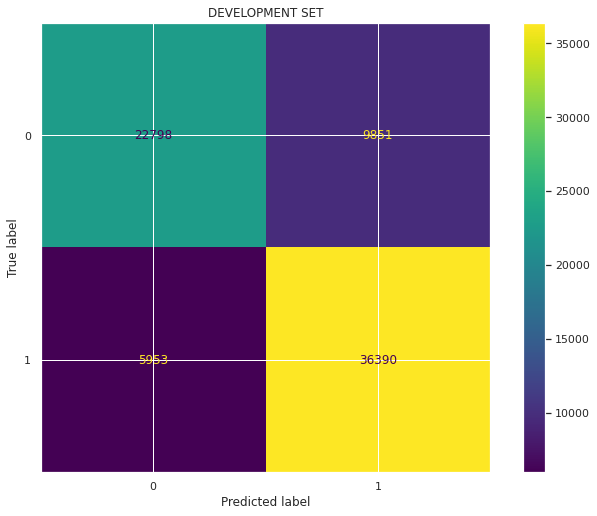

In [ ]:
best_params_bow = development(X_dev_cv, y_dev)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


Best hyerparameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 0.23357214690901212}
Best score: 0.7239305645668639
The best hyperparameters from the model with the best score are the following: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 0.23357214690901212}
dev f1-score: 76.92%
              precision    recall  f1-score   support

           0       0.71      0.62      0.66     32649
           1       0.73      0.81      0.77     42343

    accuracy                           0.73     74992
   macro avg       0.72      0.71      0.72     74992
weighted avg       0.73      0.73      0.72     74992




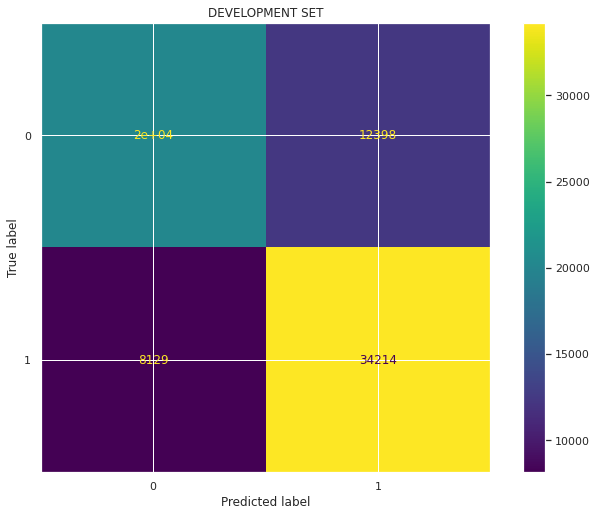

In [ ]:
best_params_emb = development(w2v_vectorized_x_dev_trunc, y_dev)

### Logistic Regression with TF-IDF

train f1-score: 81.18%
              precision    recall  f1-score   support

           0       0.77      0.69      0.73     65298
           1       0.78      0.84      0.81     84685

    accuracy                           0.78    149983
   macro avg       0.78      0.77      0.77    149983
weighted avg       0.78      0.78      0.78    149983




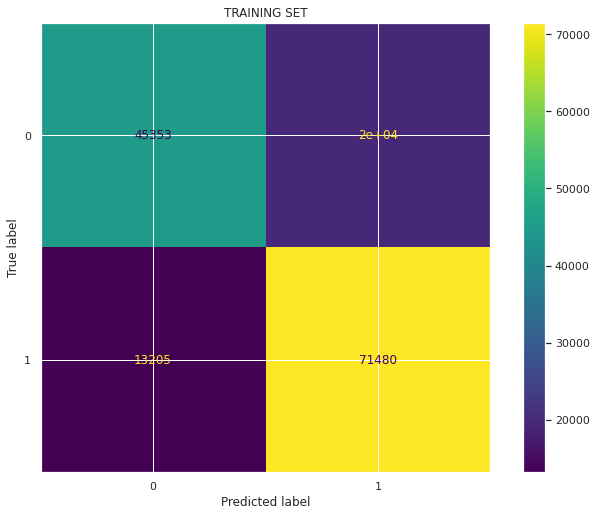

In [ ]:
opt_model_tfidf = training_metrics_and_fit(best_params_tfidf, X_train_total_tfidf, y_train_total)

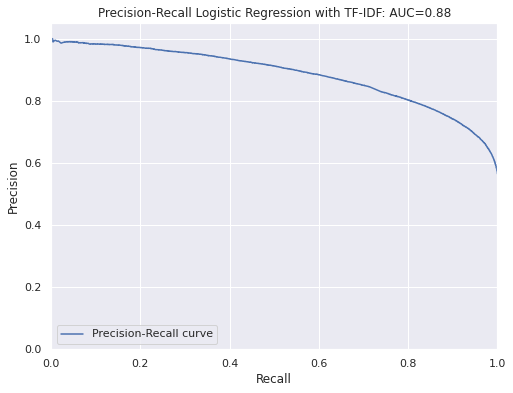

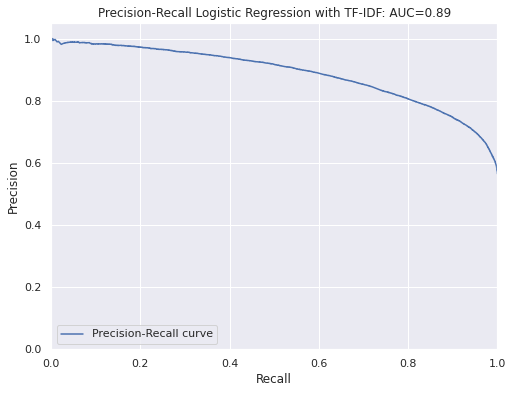

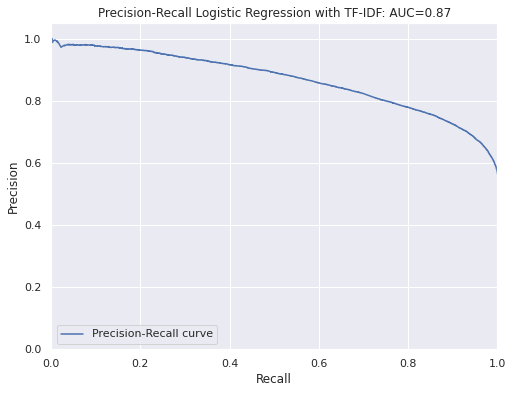

In [ ]:
prec_rec(opt_model_tfidf, X_train_tfidf, y_train)


Accuracy of logistic regression classifier on test set: 0.76
test f1-score: 79.67%
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     21766
           1       0.77      0.83      0.80     28229

    accuracy                           0.76     49995
   macro avg       0.76      0.75      0.75     49995
weighted avg       0.76      0.76      0.76     49995




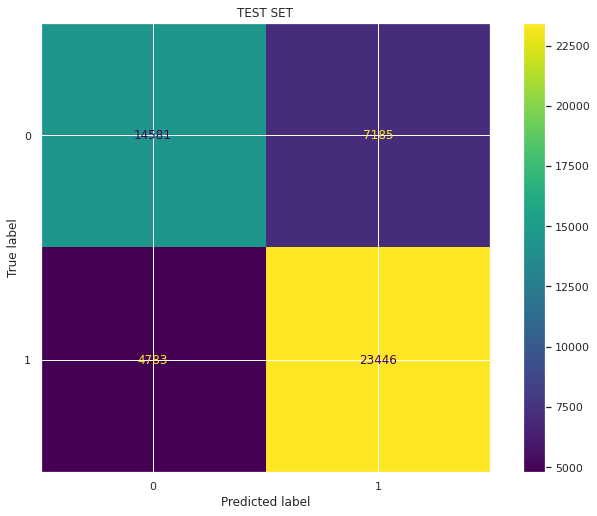

In [ ]:
testing(opt_model_tfidf, X_test_tfidf, y_test)

### Logistic Regression with BOW

train f1-score: 81.31%
              precision    recall  f1-score   support

           0       0.78      0.68      0.73     65298
           1       0.78      0.85      0.81     84685

    accuracy                           0.78    149983
   macro avg       0.78      0.77      0.77    149983
weighted avg       0.78      0.78      0.78    149983




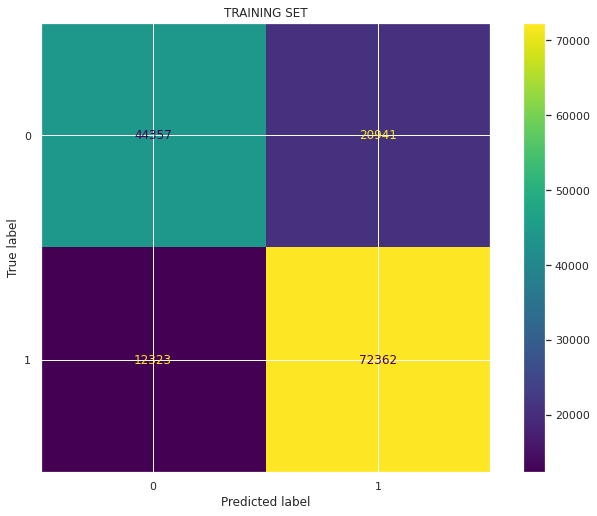

In [ ]:
opt_model_bow = training_metrics_and_fit(best_params_bow, X_train_total_cv, y_train_total)

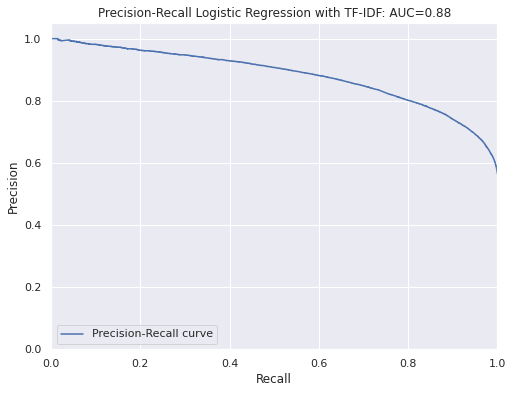

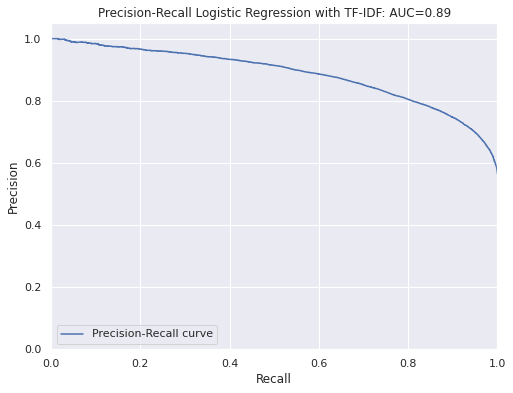

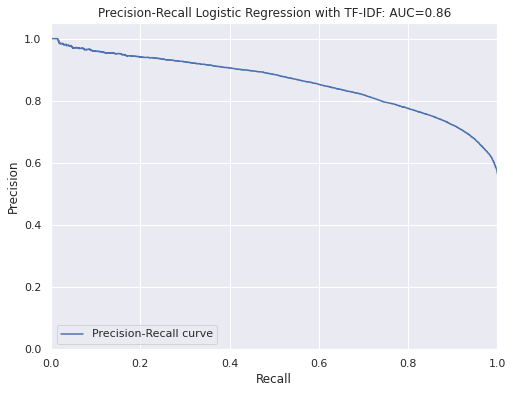

In [ ]:
prec_rec(opt_model_bow, X_train_cv, y_train)

Accuracy of logistic regression classifier on test set: 0.76
test f1-score: 79.65%
              precision    recall  f1-score   support

           0       0.76      0.65      0.70     21766
           1       0.76      0.84      0.80     28229

    accuracy                           0.76     49995
   macro avg       0.76      0.75      0.75     49995
weighted avg       0.76      0.76      0.75     49995




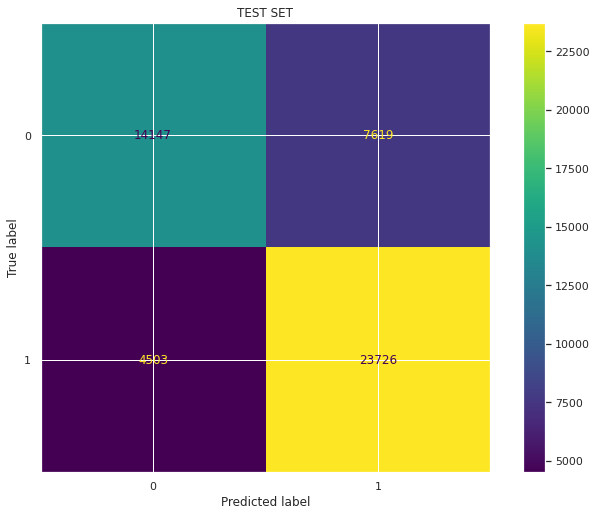

In [ ]:
testing(opt_model_bow, X_test_cv, y_test)

### Logistic Regression with Word Embeddings

train f1-score: 76.75%
              precision    recall  f1-score   support

           0       0.71      0.62      0.66     65298
           1       0.73      0.81      0.77     84685

    accuracy                           0.72    149983
   macro avg       0.72      0.71      0.71    149983
weighted avg       0.72      0.72      0.72    149983




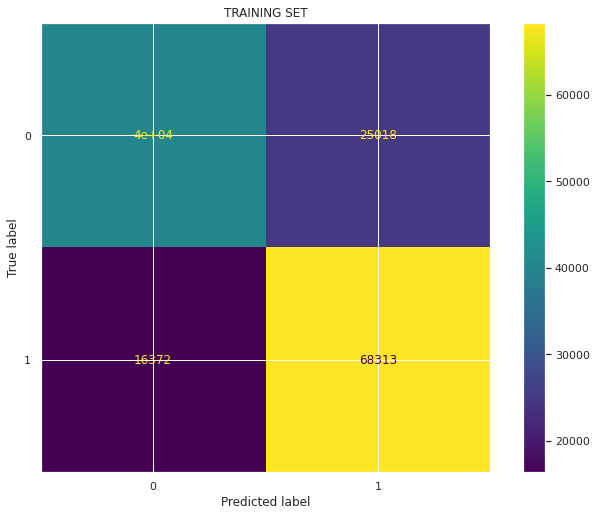

In [ ]:
opt_model_emb = training_metrics_and_fit(best_params_emb, w2v_vectorized_x_train_total, y_train_total)

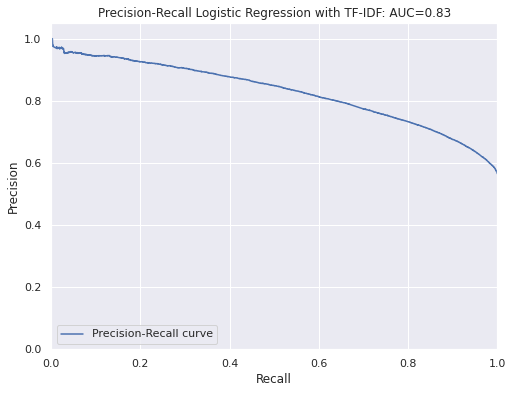

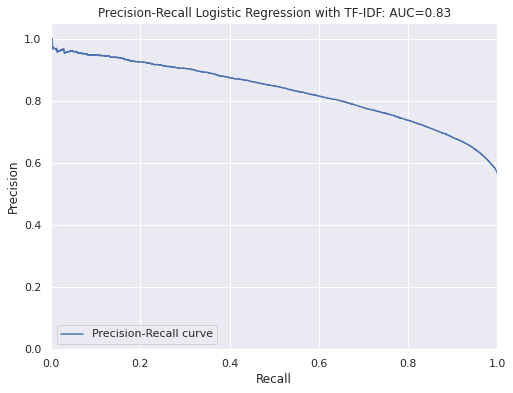

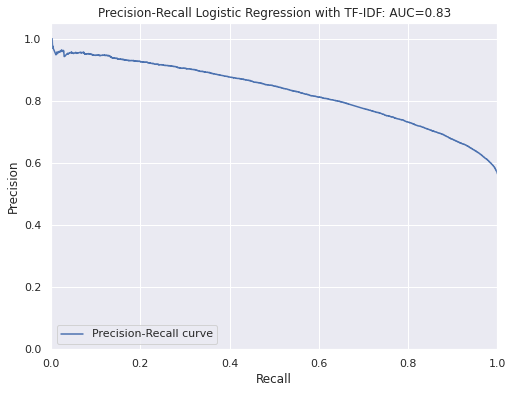

In [ ]:
prec_rec(opt_model_emb, w2v_vectorized_x_train_trunc, y_train)

Accuracy of logistic regression classifier on test set: 0.72
test f1-score: 76.55%
              precision    recall  f1-score   support

           0       0.71      0.61      0.66     21766
           1       0.73      0.81      0.77     28229

    accuracy                           0.72     49995
   macro avg       0.72      0.71      0.71     49995
weighted avg       0.72      0.72      0.72     49995




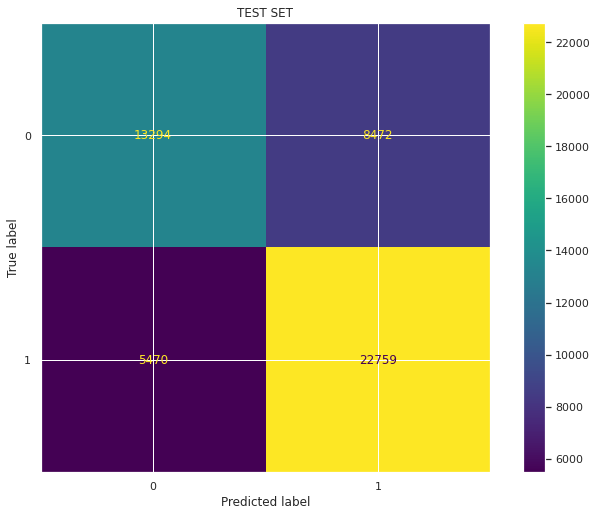

In [ ]:
testing(opt_model_emb, w2v_vectorized_x_test_trunc, y_test)

## Plots

### Tfidf Learning Curves

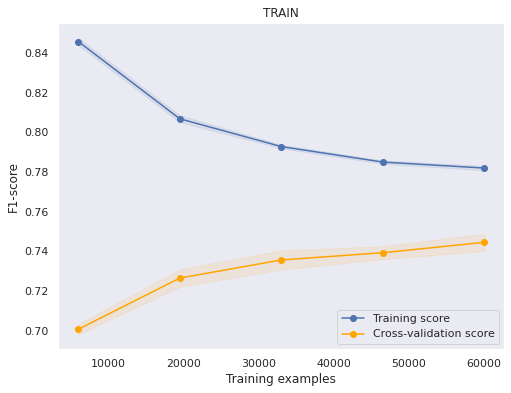

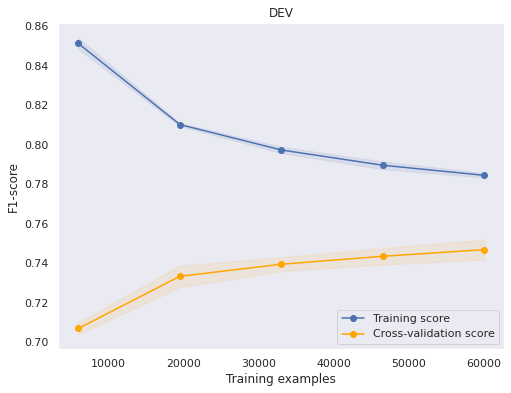

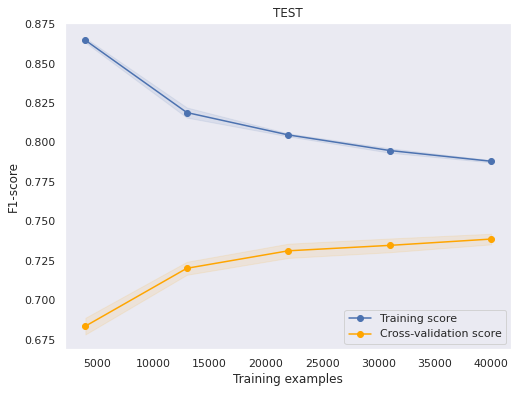

In [ ]:
learning_metrics(best_params_tfidf, X_train_tfidf, y_train, X_dev_tfidf, y_dev, X_test_tfidf, y_test)

### BOW Learning Curves

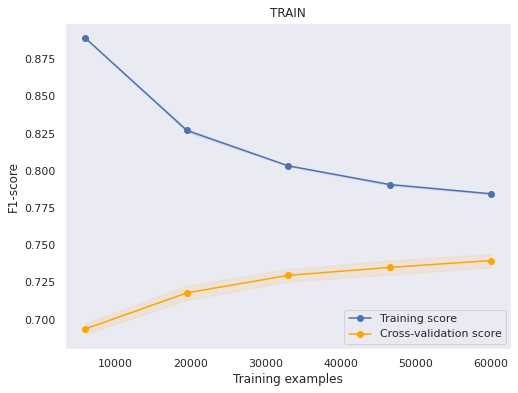

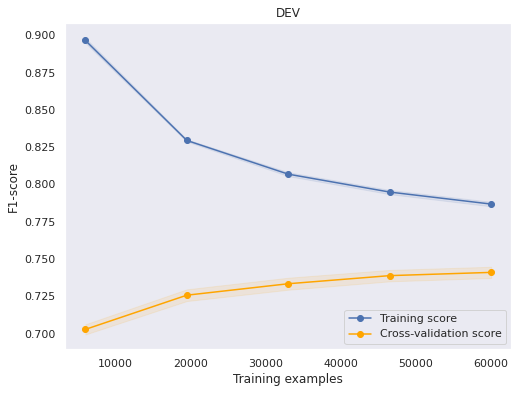

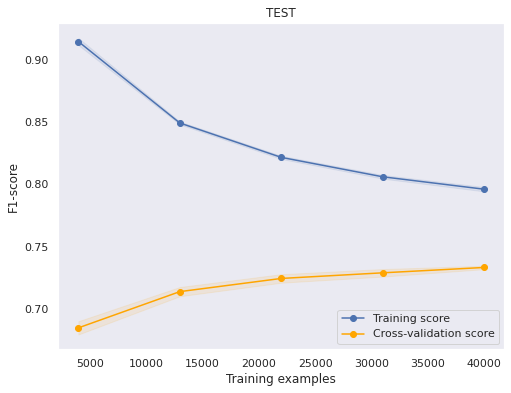

In [ ]:
learning_metrics(best_params_bow, X_train_cv, y_train, X_dev_cv, y_dev, X_test_cv, y_test)

### Word Embedings Learning Curves

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


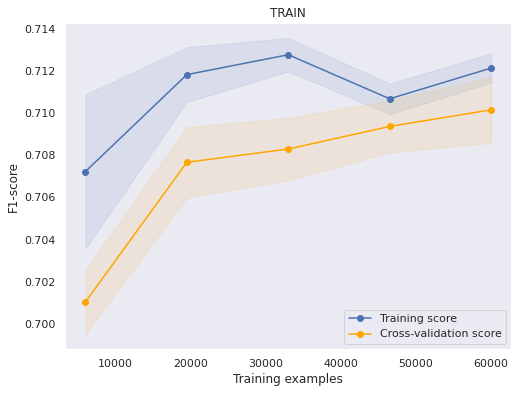

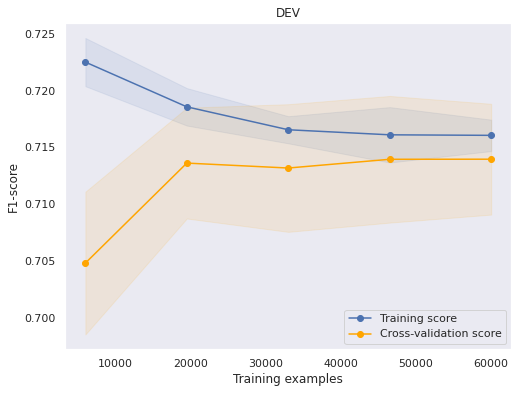

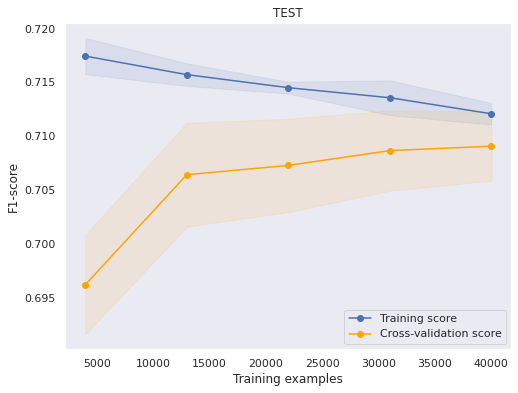

In [ ]:
learning_metrics(best_params_emb, w2v_vectorized_x_train_trunc, y_train, w2v_vectorized_x_dev_trunc, y_dev, w2v_vectorized_x_test_trunc, y_test)

### Misclassified Texts

In [ ]:
predictions = opt_model_tfidf.predict(X_test_tfidf)


In [ ]:
test_df = pd.concat([X_test.reset_index(), y_test.reset_index(), pd.DataFrame(predictions)], axis=1).reset_index()
test_df

,level_0,index,text,index,Sentiment,0
0,0,40258,oh no missed it wa ment to put it on but got d...,40258,1,0
1,1,42220,oh no just saw the roland garos website damn b...,42220,0,0
2,2,73108,aww,73108,0,0
3,3,78918,lol no adore the older one too but totally exc...,78918,1,1
4,4,57129,good night dude ll catch with ya tomorrow got ...,57129,1,1
...,...,...,...,...,...,...
49990,49990,87637,yay do you have ana pic,87637,1,1
49991,49991,20450,keerstin tell tell tell me everything,20450,1,1
49992,49992,67496,yep,67496,1,1
49993,49993,16313,gosh fucking emo wrote on status on facebook h...,16313,0,1


In [ ]:
test_df[test_df['Sentiment']!=test_df['level_0']]


,level_0,index,text,index,Sentiment,0
0,0,40258,oh no missed it wa ment to put it on but got d...,40258,1,0
1,1,42220,oh no just saw the roland garos website damn b...,42220,0,0
2,2,73108,aww,73108,0,0
3,3,78918,lol no adore the older one too but totally exc...,78918,1,1
4,4,57129,good night dude ll catch with ya tomorrow got ...,57129,1,1
...,...,...,...,...,...,...
49990,49990,87637,yay do you have ana pic,87637,1,1
49991,49991,20450,keerstin tell tell tell me everything,20450,1,1
49992,49992,67496,yep,67496,1,1
49993,49993,16313,gosh fucking emo wrote on status on facebook h...,16313,0,1


## Optimization of Logistic Regression with BOW

* For this optimization we are going to use the BOW model with the hyperparameters that were extracted during the development phase, but the input data will be a set with all the potential features the `CountVectorizer` can generate rather than the 5000 we used previously. 
* By doing this we reach the best performance. 

In [ ]:
cv_opt = CountVectorizer(binary=False, min_df=0.0, max_df=1.0 , ngram_range=(1,2), stop_words = stopwords.words('english'))

X_train_total_cv_opt = cv_opt.fit_transform(X_train_total)
X_test_cv_opt = cv_opt.transform(X_test)

In [ ]:
X_train_total_cv_opt.shape

(149983, 406907)

train f1-score: 98.24%
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     65298
           1       0.97      0.99      0.98     84685

    accuracy                           0.98    149983
   macro avg       0.98      0.98      0.98    149983
weighted avg       0.98      0.98      0.98    149983




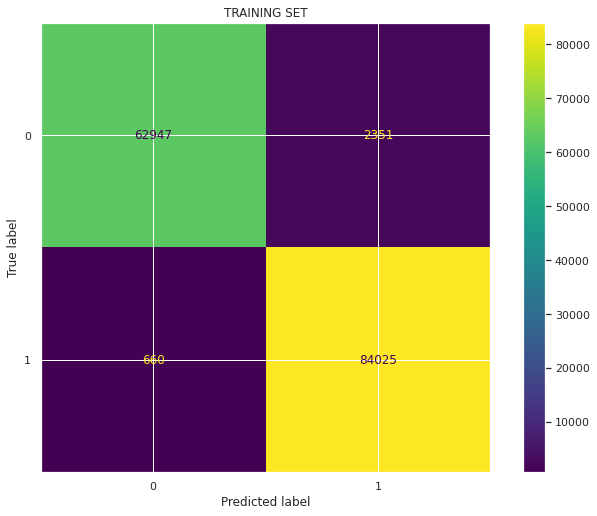

In [ ]:
opt_model_bow_2 = training_metrics_and_fit(best_params_bow, X_train_total_cv_opt, y_train_total)

Accuracy of logistic regression classifier on test set: 0.92
test f1-score: 92.75%
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     21766
           1       0.91      0.95      0.93     28229

    accuracy                           0.92     49995
   macro avg       0.92      0.91      0.91     49995
weighted avg       0.92      0.92      0.92     49995




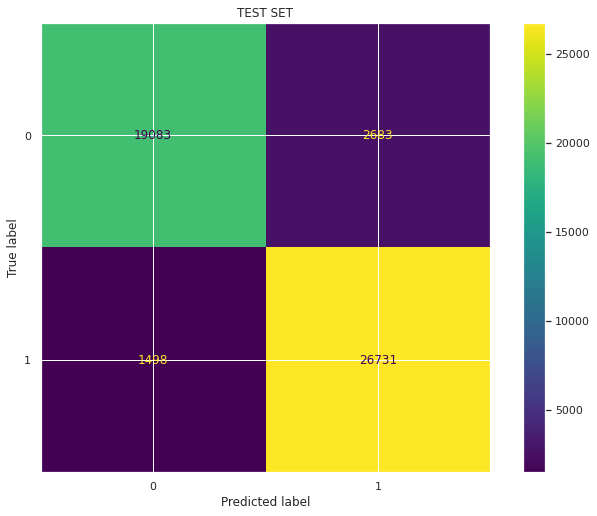

In [ ]:
testing(opt_model_bow_2, X_test_cv_opt, y_test)

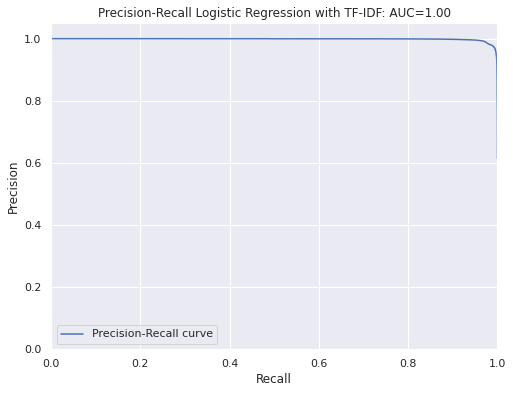

In [ ]:
prec_rec(opt_model_bow_2, X_train_total_cv_opt, y_train_total)

## Pycaret 


[PyCaret](https://pycaret.org/) is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive.

* Since PyCaret takes care of the Train/Dev inside the pipeline, we will split the data into two sets. One for development and one for testing.
* In order to keep the same test-set and have comparable results witht the previous methods we will combine the previous `X_train` and `X_dev' sets.

In [ ]:
# init setup
from pycaret.classification import *

In [ ]:
A_n = sparse.vstack([X_train_cv]).toarray()

* Since the goal of this section is to get a high level overview of the various models, we will keep only a fraction of the data, to speed things up. If we had more resources (Mainly RAM) we would use a much higher number of rows.

In [ ]:
selection = 2000
df = pd.DataFrame(A_n[:selection])
df['y'] = pd.concat([y_train], ignore_index=True)[:selection]
del A_n
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,4751,4752,4753,4754,4755,4756,4757,4758,4759,4760,4761,4762,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802,4803,4804,4805,4806,4807,4808,4809,4810,4811,4812,4813,4814,4815,4816,4817,4818,4819,4820,4821,4822,4823,4824,4825,4826,4827,4828,4829,4830,4831,4832,4833,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4845,4846,4847,4848,4849,4850,4851,4852,4853,4854,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864,4865,4866,4867,4868,4869,4870,4871,4872,4873,4874,4875,4876,4877,4878,4879,4880,4881,4882,4883,4884,4885,4886,4887,4888,4889,4890,4891,4892,4893,4894,4895,4896,4897,4898,4899,4900,4901,4902,4903,4904,4905,4906,4907,4908,4909,4910,4911,4912,4913,4914,4915,4916,4917,4918,4919,4920,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940,4941,4942,4943,4944,4945,4946,4947,4948,4949,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

* Pycaret gives the option of performing various pre-processing steps in the `setup` function, like PCA, clustering, normalization and many more. 
* We did not see any significant improvement with any pre-processing steps, thus we did not give any argument in the function.
* We could not run PCA (which we normally would to accelerate the development, since google colab crashed).

In [ ]:
s = setup(data = df, target = 'y', session_id=123,  silent=True)

,Description,Value
0,session_id,123
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2000, 5001)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,5000
8,Ordinal Features,False
9,High Cardinality Features,False


* Having pre-processed the dataset, we can see the comparison of various models. We can exclude some models that are known to take a lot of time. 

In [ ]:
best_model = compare_models(sort = 'F1', exclude = ['xgboost', 'catboost', 'lda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6362,0.6749,0.9217,0.6244,0.7442,0.1876,0.2396,2.776
ada,Ada Boost Classifier,0.6290,0.6655,0.9093,0.6213,0.7379,0.1737,0.2168,1.326
dummy,Dummy Classifier,0.5747,0.5000,1.0000,0.5747,0.7299,0.0000,0.0000,0.023
lightgbm,Light Gradient Boosting Machine,0.6411,0.6567,0.8383,0.6442,0.7282,0.2252,0.2449,0.707
lr,Logistic Regression,0.6369,0.6915,0.7414,0.6655,0.7009,0.2420,0.2453,3.138
ridge,Ridge Classifier,0.6340,0.0000,0.7152,0.6707,0.6914,0.2422,0.2440,0.328
rf,Random Forest Classifier,0.6376,0.6839,0.6878,0.6833,0.6853,0.2578,0.2582,1.878
et,Extra Trees Classifier,0.6283,0.6687,0.6841,0.6734,0.6778,0.2379,0.2387,2.637
svm,SVM - Linear Kernel,0.6290,0.0000,0.6789,0.6899,0.6727,0.2362,0.2422,0.662
knn,K Neighbors Classifier,0.6004,0.6263,0.6641,0.6495,0.6556,0.1788,0.1798,2.758


In [ ]:
# print the best model based on F1 score
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [ ]:
# Tune the model (increased number of iteration result to better performance)
tuned = tune_model(best_model, n_iter = 10, optimize = 'F1', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6071,0.6113,0.9753,0.5985,0.7418,0.0872,0.1638
1,0.5714,0.7135,0.9877,0.5755,0.7273,-0.0142,-0.0724
2,0.5857,0.6806,0.9753,0.5852,0.7315,0.0299,0.0696
3,0.6071,0.6905,1.0000,0.5956,0.7465,0.0776,0.2009
4,0.5714,0.7094,0.9625,0.5746,0.7196,0.0141,0.0305
5,0.5857,0.6701,1.0000,0.5797,0.7339,0.0379,0.1390
6,0.6071,0.6915,0.9750,0.5954,0.7393,0.1026,0.1850
7,0.6071,0.6435,0.9750,0.5954,0.7393,0.1026,0.1850
8,0.6071,0.7378,1.0000,0.5926,0.7442,0.0941,0.2222


## Precision-Recall Curve

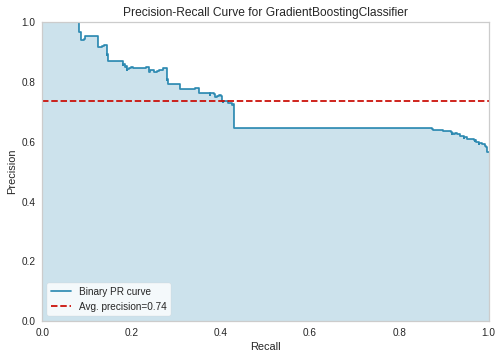

In [ ]:
plot_model(tuned, plot = 'pr')

## Perform predictions on hold-out set

In [ ]:
_ = predict_model(tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6539,0.7085,0.9364,0.623,0.7482,0.2606,0.3228


## Train the final model on the complete dataset.

In [ ]:
# finalize tuned_ridge model
final = finalize_model(tuned)

# print final model parameters
print(final)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## Predictions on unseen data

* If needed, uncomment the section below and edit the code. Please note that all the pre-processing steps should be excecuted on the unseed_df

In [ ]:
# provide unseed data below:
A_n = sparse.vstack([X_test_cv]).toarray()
selection = 200
df_test = pd.DataFrame(A_n[:selection])
df_test['y'] = pd.concat([y_train], ignore_index=True)[:selection]
del A_n
df_test.head()


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
unseen_predictions = predict_model(final, data=df_test)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.55,0.4955,0.8716,0.5556,0.6786,0.0386,0.0515


,0,1,2,3,4,5,6,7,8,9,...,4993,4994,4995,4996,4997,4998,4999,y,Label,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.5732
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.5732
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.5732
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.6019
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.6422


In [ ]:
# check metric on unseen data (provided it is in the same format sas the data)
from pycaret.utils import check_metric
check_metric(unseen_predictions['y'], unseen_predictions['Label'], metric = 'F1')

0.6786